# MOTORBIKE AMBULANCE CALLS ANALYSIS
## REGRESSION

In [42]:
# libraries for regression part
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import (cross_val_predict, cross_val_score,train_test_split, GridSearchCV)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVR

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt

In [4]:
# dataset loading
data = pd.read_csv("motorbike_ambulance_calls.csv", index_col=0)

In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Select provided features.
    Parameters
    ----------
    features : list(str)
        A list of features to select.
    """
    def __init__(self, features=None):
        self.features = features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        Select columns from the input.
        Parameters
        ----------
        X : pandas.DataFrame
        """
        return X[self.features]


class CategoricalTransformer(BaseEstimator, TransformerMixin):
    """Prepare categorical features.
    Parameters
    ----------
    categories : ‘auto’ or a list of lists/arrays of values, default=’auto’.
        Categories (unique values) per feature:
            ‘auto’ : Determine categories automatically from the training data.
            list : categories[i] holds the categories expected in the i-th
            column. The passed categories should not mix strings and numeric
            values within a single feature, and should be sorted in case of
            numeric values.
    """
    def __init__(self, categories='auto'):
        self.categories = categories
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Transform categorical data.
        Parameters
        ----------
        X : pandas.DataFrame
            Input categorical features.
        """
        enc = OneHotEncoder(categories=self.categories, sparse=False)
        enc.fit(X)
        X_onehot = enc.transform(X)

        return X_onehot

In [30]:
# let's prepare the data and pipeline
num_features = [ 'temp', 'hr', 'hum']
cat_features = [ 'weathersit']
cat_values = [[1, 2, 3, 4]]


num_pipeline = Pipeline([
    ('fs', FeatureSelector(features=num_features)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('fs', FeatureSelector(features=cat_features)),
    ('ct', CategoricalTransformer(categories=cat_values))
])

data_pipeline = FeatureUnion([
    ('num', num_pipeline),
    ('cat', cat_pipeline)
])

In [31]:
# SELECT THE BEST REGRESSION MODEL

rnd_st = 42
cv = 5

y = data['cnt']
X = data.drop('cnt', axis=1)

regr_models = [
    ('Ridge', Ridge(random_state=rnd_st)),
    ('Lasso', Lasso(random_state=rnd_st)),
    ('RFR', RandomForestRegressor(n_estimators=100, random_state=rnd_st,
        n_jobs=-1)),
    ('SVR', SVR(gamma='scale'))
]

mae_scores = np.zeros(len(regr_models))
pred_cols = [r[0] for r in regr_models]
pred_cols.append('y')
predictions = pd.DataFrame(columns=pred_cols, dtype=float, index=X.index)
predictions['y'] = y

for index, (reg_name, reg) in enumerate(regr_models):
    reg_pipe = Pipeline([
        ('pipe', data_pipeline),
        (reg_name, reg)
        ])
    
    scores = -1 * cross_val_score(reg_pipe, X, y, cv=cv,
        scoring='neg_mean_absolute_error')
    predictions[reg_name] = cross_val_predict(reg_pipe, X, y, cv=cv, n_jobs=-1)
    
    mae = scores.mean()
    std = scores.std()
    print(f'{reg_name}, MAE = {mae}, std = {std}')

    mae_scores[index] = mae

print(f'The best regressor was {regr_models[np.argmin(mae_scores)][0]}')

Ridge, MAE = 116.8679932420157, std = 22.347064953157062
Lasso, MAE = 116.89706457730821, std = 22.50235673704424
RFR, MAE = 87.81417441511584, std = 13.166101704889758
SVR, MAE = 92.57615094644511, std = 27.198774773873893
The best regressor was RFR


In [32]:
# use Grid search to find the best parameters for Random Forest Regressor

param_grid = { 
    "RFR__n_estimators": [20, 50, 100, 200],
    "RFR__max_features": ['auto', 'sqrt'],
    "RFR__max_depth": [None, 2, 5]
}

reg_pipe = Pipeline([
        ('pipe', data_pipeline),
        ('RFR',  RandomForestRegressor(n_jobs=-1, random_state=rnd_st))
        ])

clf = GridSearchCV(reg_pipe, param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)


clf.fit(X, y)

print(f'RFR best score {-1 * clf.best_score_}')
print(f'Best parameters {clf.best_params_}')

RFR best score 85.2424416249825
Best parameters {'RFR__max_depth': 5, 'RFR__max_features': 'auto', 'RFR__n_estimators': 50}


In [33]:
best_params = {key[5:]:value for key, value in clf.best_params_.items()}
best_params['random_state'] = rnd_st

reg_best_pipe = Pipeline([
    ('pipe', data_pipeline),
    (reg_name, RandomForestRegressor(**best_params))
    ])

predictions['RFR_best'] = cross_val_predict(reg_best_pipe, X, y, cv=cv, n_jobs=-1)
scores = cross_val_score(reg_best_pipe, X, y, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_error')

print(f'RFR_best MAE = {-1 * scores.mean()}, STD = {scores.std()}')

RFR_best MAE = 85.2424416249825, STD = 12.396772230504542


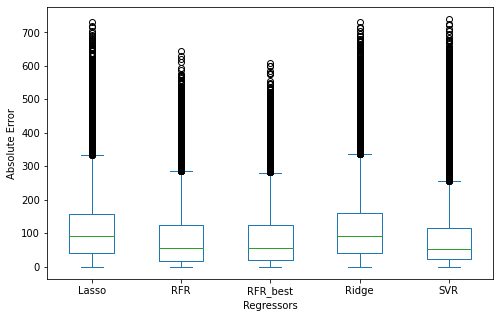

In [34]:
# let's get plots => box and bar

ordered_columns = list(sorted(predictions.drop(['y'], axis=1).columns))

mae = pd.DataFrame(index=predictions.index)

for c in ordered_columns:
    mae[c] = np.abs(predictions[c] - predictions['y'])

mae.plot(kind='box', figsize=(8, 5))
plt.xlabel('Regressors')
plt.ylabel('Absolute Error')
plt.savefig('./mae_regr_boxplot.png')
plt.show()

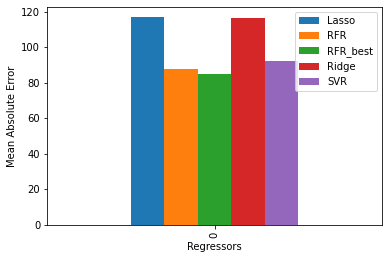

In [35]:
mae = pd.DataFrame(index=[0])

for c in ordered_columns:
    mae[c] = np.mean(np.abs(predictions[c] - predictions['y']))

mae.plot(kind='bar')
plt.xlabel('Regressors')
plt.ylabel('Mean Absolute Error')
plt.savefig('./mae_regr_barplot.png')
plt.show()

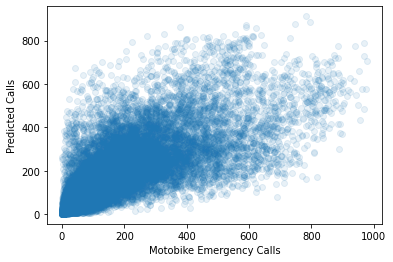

In [36]:
plt.scatter(predictions['y'], predictions['RFR'], alpha=0.1)
plt.xlabel('Motobike Emergency Calls')
plt.ylabel('Predicted Calls')
plt.savefig('./rfr_pred_vs_actual.png')
plt.show()

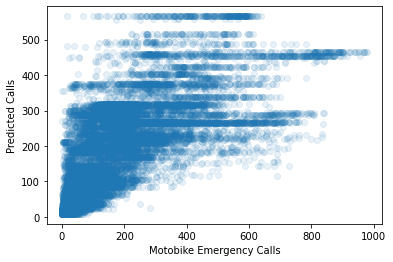

In [37]:
plt.scatter(predictions['y'], predictions['RFR_best'], alpha=0.1)
plt.xlabel('Motobike Emergency Calls')
plt.ylabel('Predicted Calls')
plt.savefig('./rfr_best_pred_vs_actual.png')
plt.show()

## EVENT AND ANOMALY DETECTION

In [38]:
from sklearn.decomposition import PCA

Explained variance 0.9068130117043918


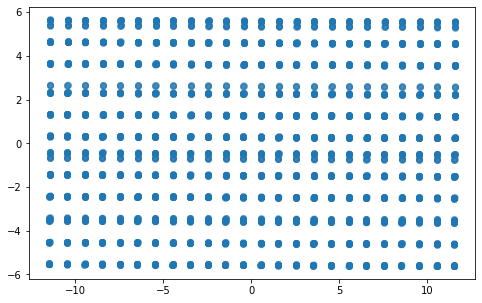

In [43]:
season_encoder = LabelEncoder()
season_encoder.fit(data.season)
data['season'] = season_encoder.transform(data.season)

X = data.drop(['cnt', 'date'], axis=1)

pca = PCA(n_components=2)
pca.fit(X)
X_pca2 = pca.transform(X)

print(f'Explained variance {pca.explained_variance_ratio_.sum()}')

plt.figure(figsize=(8, 5))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], alpha=0.1)
plt.show()

In [44]:
data['cnt'].describe()

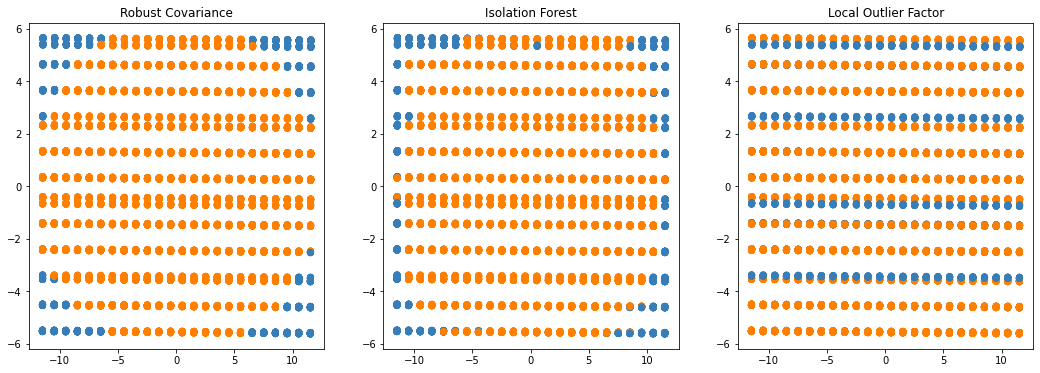

In [54]:
# Look for outliers
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# use PCA's output
X = X_pca2

n_samples = len(X)
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
lof_n_neigbors = 35


clusters = {}

# define outlier/anomaly detection methods to be compared
det_algs = [
    ("Robust Covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=rnd_st)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=lof_n_neigbors, contamination=outliers_fraction))]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for index, (alg_name, alg) in enumerate(det_algs):
    if alg_name == "Local Outlier Factor":
        y_pred = alg.fit_predict(X)
    else:
        y_pred = alg.fit(X).predict(X)
    
    clusters[alg_name] = y_pred
    colors = np.array(['#377eb8', '#ff7f00'])
    plt.subplot(131 + index)
    plt.scatter(X[:, 0], X[:, 1], c=colors[(y_pred + 1) // 2])
    plt.title(alg_name)

plt.savefig('./outlier_det_2d.png')
plt.show()

In [47]:
clusters

{'Robust Covariance': array([-1, -1, -1, ..., -1, -1, -1]),
 'Isolation Forest': array([-1, -1, -1, ..., -1, -1, -1]),
 'Local Outlier Factor': array([ 1,  1,  1, ..., -1, -1, -1])}

## Test on Regression

In [49]:

mae_scores = np.zeros(len(clusters))

for index, (c_name, c_values)  in enumerate(clusters.items()):
    
    print(f'Data shape with outliers {data.shape} for {c_name}')
    # select inliers only
    X = data.loc[(c_values + 1).astype(bool)]

    print(f'Data shape without outliers {X.shape} for {c_name}')

    y = X['cnt']
    X = X.drop('cnt', axis=1)
    
    reg_pipe = Pipeline([
        ('pipe', data_pipeline),
        ('RFR', RandomForestRegressor(n_estimators=50, max_depth=5, max_features='auto', random_state=rnd_st,
            n_jobs=-1)),
        ])
    
    scores = -1 * cross_val_score(reg_pipe, X, y, cv=cv,
        scoring='neg_mean_absolute_error', n_jobs=-1)
    
    mae = scores.mean()
    std = scores.std()
    print(f'RFR with {c_name}, MAE = {mae}, std = {std}')

    mae_scores[index] = mae

Data shape with outliers (17379, 14) for Robust Covariance
Data shape without outliers (14772, 14) for Robust Covariance
RFR with Robust Covariance, MAE = 92.8436431199759, std = 11.363502396527918
Data shape with outliers (17379, 14) for Isolation Forest
Data shape without outliers (14773, 14) for Isolation Forest
RFR with Isolation Forest, MAE = 92.88111983473001, std = 10.995460367300963
Data shape with outliers (17379, 14) for Local Outlier Factor
Data shape without outliers (14772, 14) for Local Outlier Factor
RFR with Local Outlier Factor, MAE = 87.5982692427616, std = 14.360103042487593


## PCA, 3D

In [50]:
# Dimensionality reduction with PCA

from mpl_toolkits.mplot3d import Axes3D

Explained variance 0.9678359490258028


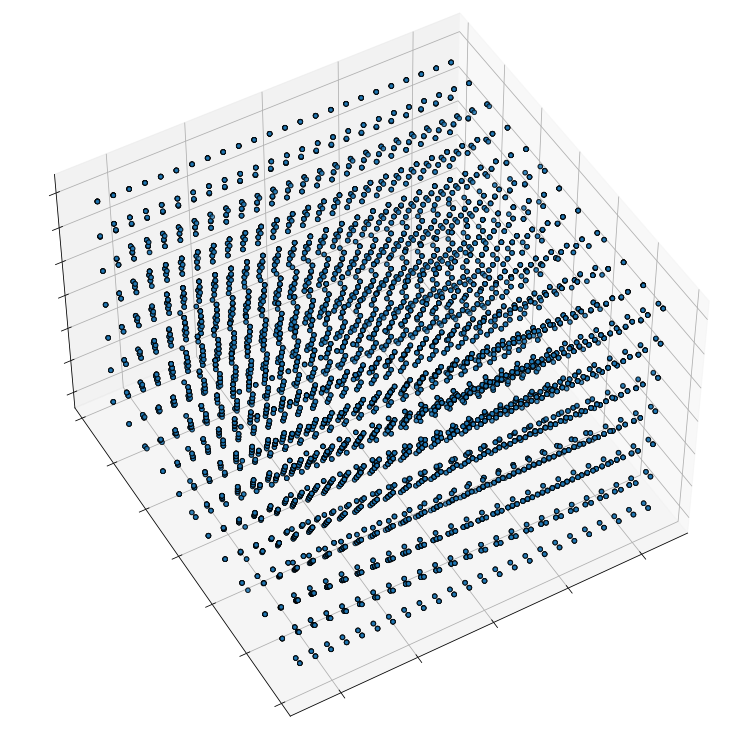

In [53]:
X = data.drop(['date', 'cnt'], axis=1)

pca = PCA(n_components=3)
pca.fit(X)

X_pca3 = pca.transform(X)

print(f'Explained variance {pca.explained_variance_ratio_.sum()}')

fig = plt.figure(1, figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=60)
ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

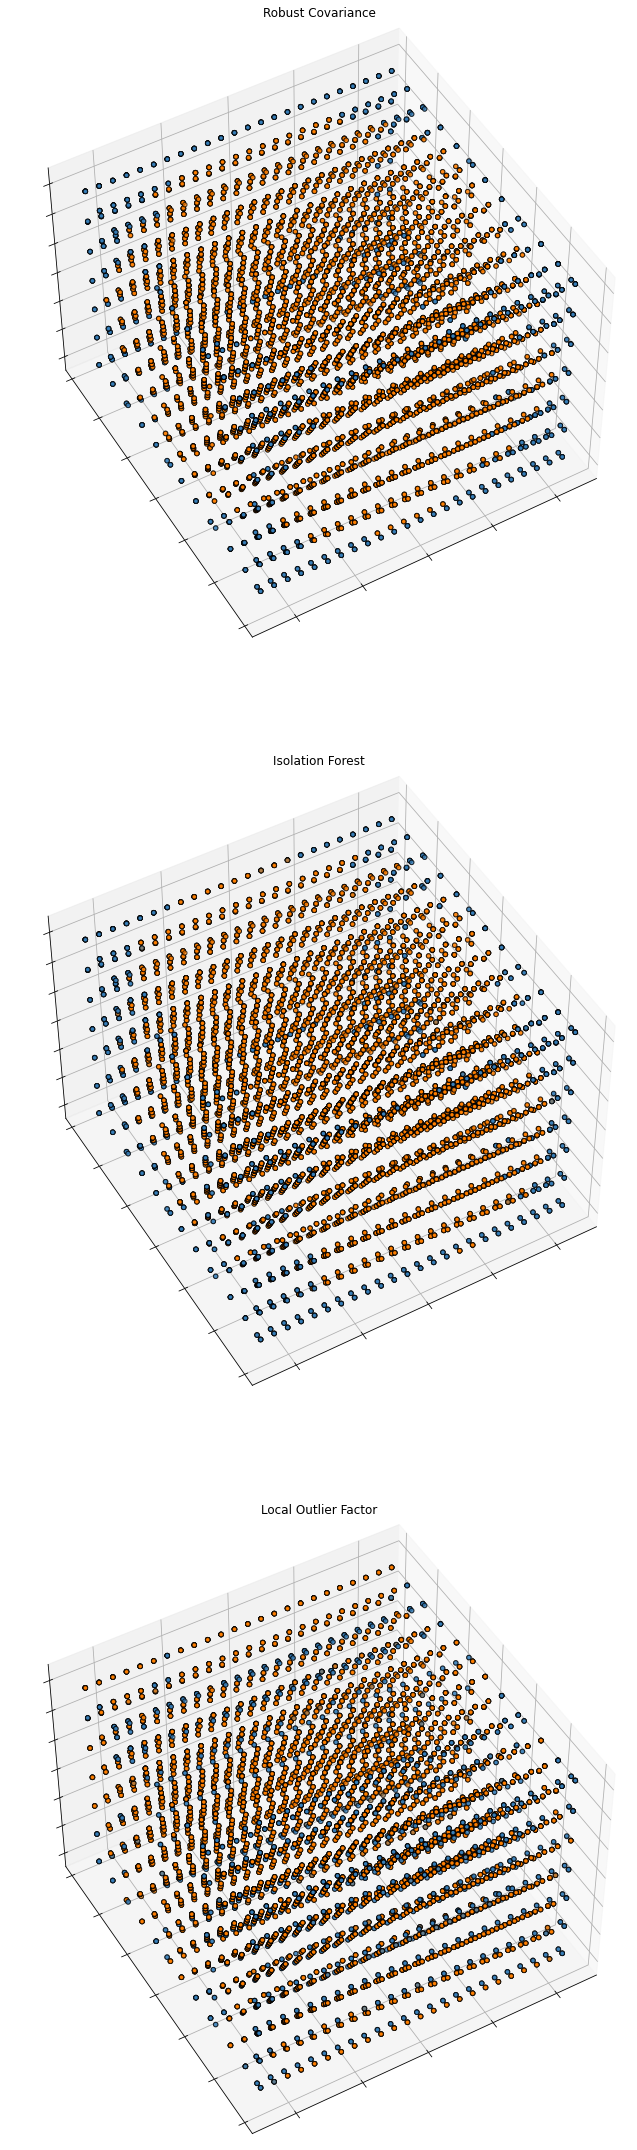

In [55]:
# Look for outliers
# use PCA's output
X = X_pca3

n_samples = len(X)
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
lof_n_neigbors = 35


# define outlier/anomaly detection methods to be compared
det_algs = [
    ("Robust Covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=rnd_st)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=lof_n_neigbors, contamination=outliers_fraction))]

fig = plt.figure(figsize=(15, 39))

for index, (alg_name, alg) in enumerate(det_algs):
    if alg_name == "Local Outlier Factor":
        y_pred = alg.fit_predict(X)
    else:
        y_pred = alg.fit(X).predict(X)

    colors = np.array(['#377eb8', '#ff7f00'])
    
    ax = fig.add_subplot(311 + index, projection='3d', elev=48, azim=60)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors[(y_pred + 1) // 2], edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_title(alg_name)
plt.show()